In [3]:
import pandas as pd
import seaborn as sns
import os
import matplotlib.pyplot as plt
from aequitas.group import Group
from aequitas.bias import Bias
from aequitas.fairness import Fairness

In [4]:
df_all = pd.read_csv(os.path.join('dat','savry_for_aequitas.csv'))
df=df_all[['entity_id', 'score', 'label_value', 'race', 'sex', 'age_cat']]
df.head()

,entity_id,score,label_value,race,sex,age_cat
0,691,True,True,Espanyol,Home,14 i 15 anys
1,956,True,True,Espanyol,Dona,14 i 15 anys
2,2560,True,True,Magrib,Home,14 i 15 anys
3,2018,True,True,Magrib,Home,14 i 15 anys
4,1650,True,True,Espanyol,Home,16 i 17 anys


In the bar chart below, we see a large difference in how these scores are distributed by race, 

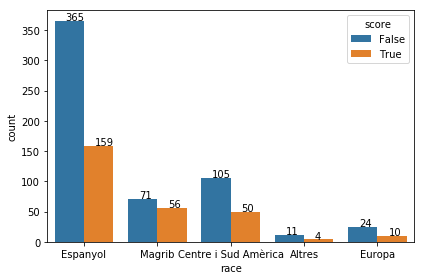

In [5]:
g  =  sns.countplot(x="race", hue="score", data=df)
for p in g.patches:
    g.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.15, p.get_height()+1))
plt.tight_layout()
plt.show()

We defined recidivism as a new arrest within 5 years. (If a person recidivates, label_value = 1).

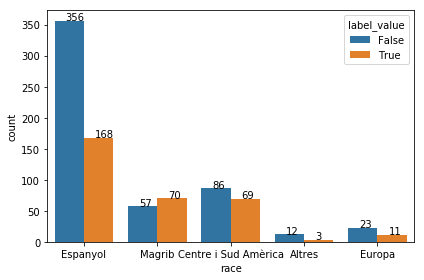

In [6]:
g  =  sns.countplot(x="race", hue="label_value", data=df)
for p in g.patches:
    g.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.15, p.get_height()+1))
plt.tight_layout()
plt.show()

Practitioners face the challenge of determining whether or not such patterns reflect bias or not. The fact that we have multiple ways to measure bias adds complexity to the decisionmaking process. With Aequitas, we provide a tool that automates the reporting of various fairness metrics to aid in this process.

Applying Aequitas progammatically is a three step process represented by three python classes:

Group(): Define groups

Bias(): Calculate disparities

Fairness(): Assert fairness

Each class builds on the previous one expanding the output DataFrame.

Group()
Aequitas expects a dataframe with predefined columns score, and label_value and treats other columns (with a few exceptions) as attributes against which to test for disparities. In this cases we include race, sex and age_cat.

In [7]:
g = Group()
xtab, _ = g.get_crosstabs(df)

model_id, score_thresholds 1 {'rank_abs': [279]}
COUNTS::: race
Altres                   15
Centre i Sud Amèrica    155
Espanyol                524
Europa                   34
Magrib                  127
dtype: int64
COUNTS::: sex
Dona    108
Home    747
dtype: int64
COUNTS::: age_cat
14 i 15 anys    273
16 i 17 anys    577
pd.np.nan         5
dtype: int64


In [8]:
# Here's a subset of the crosstab data
xtab[['attribute_name', 'attribute_value', 'fpr', 'fnr', 'tpr', 'tnr', 'for', 'fdr', 'group_size']].round(2)

,attribute_name,attribute_value,fpr,fnr,tpr,tnr,for,fdr,group_size
0,race,Altres,0.25,0.67,0.33,0.75,0.18,0.75,15
1,race,Centre i Sud Amèrica,0.23,0.57,0.43,0.77,0.37,0.40,155
2,race,Espanyol,0.26,0.60,0.40,0.74,0.27,0.57,524
3,race,Europa,0.17,0.45,0.55,0.83,0.21,0.40,34
4,race,Magrib,0.37,0.50,0.50,0.63,0.49,0.38,127
5,sex,Dona,0.23,0.50,0.50,0.77,0.14,0.65,108
6,sex,Home,0.27,0.57,0.43,0.73,0.34,0.48,747
7,age_cat,14 i 15 anys,0.28,0.55,0.45,0.72,0.40,0.42,273
8,age_cat,16 i 17 anys,0.26,0.57,0.43,0.74,0.28,0.54,577
9,age_cat,pd.np.nan,0.00,1.00,0.00,1.00,0.20,NaN,5


Interpreting the crosstab We see that Magrebians have a false positive rate (fpr) of 37%, while Europeans have a false positive rate of only 17% and Spanish 26%. This means that Magrebians are far more likely to be falsely labeled as high-risk than other ethnicities. On the otherhand false ommision rates (for) and false discovery rates (fdr) are much closer for all groups.

Bias()
We calculate disparities as a ratio of a metric for a group of interest compared to a base group.

In [9]:
b = Bias()
bdf = b.get_disparity_predefined_groups(xtab, {'race':'Espanyol', 'sex':'Home', 'age_cat':'14 i 15 anys'})

get_disparity_predefined_group()


In [10]:
bdf[['attribute_name', 'attribute_value', 'ppr_disparity', 'pprev_disparity', 'fdr_disparity', 'for_disparity',
       'fpr_disparity', 'fnr_disparity']]

,attribute_name,attribute_value,ppr_disparity,pprev_disparity,fdr_disparity,for_disparity,fpr_disparity,fnr_disparity
0,race,Altres,0.025157,0.878826,1.310440,0.663636,0.978022,1.120000
1,race,Centre i Sud Amèrica,0.314465,1.063096,0.698901,1.355714,0.909788,0.949565
2,race,Espanyol,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
3,race,Europa,0.062893,0.969293,0.698901,0.760417,0.680363,0.763636
4,race,Magrib,0.352201,1.453177,0.655220,1.799296,1.441296,0.840000
5,sex,Dona,0.125000,0.864583,1.344538,0.419328,0.875513,0.879412
6,sex,Home,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
7,age_cat,14 i 15 anys,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
8,age_cat,16 i 17 anys,1.846939,0.873855,1.294165,0.694444,0.908791,1.034049
9,age_cat,pd.np.nan,0.000000,0.000000,NaN,0.500000,0.000000,1.814286


Interpreting the disparity ratios The differences in False Positive Rates, noted above, are clarified using the disparity ratio (fpr_disparity). Magrebians are falsely identified as being high or medium risks 1.79 times the rate for Spanish people. 

As seen above, False Discovery Rates have much less disparity (fdr_disparity). False discovery is the fraction of false postives over predicted positive in a group. COMPAS is calibrated to have these balanced across groups.

Notice that reference groups have disparity = 1 by design

Fairness()
Finally, the Fairness() class provides three functions that provide a high level summary. 

In [11]:
f = Fairness()
fdf = f.get_group_value_fairness(bdf)

In [12]:
gaf = f.get_group_attribute_fairness(fdf)
gaf

,model_id,score_threshold,attribute_name,Statistical Parity,Impact Parity,FDR Parity,FPR Parity,FOR Parity,FNR Parity,TPR Parity,TNR Parity,NPV Parity,Precision Parity,TypeI Parity,TypeII Parity,Equalized Odds,Unsupervised Fairness,Supervised Fairness
0,1,binary 0/1,age_cat,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,1,binary 0/1,race,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False
2,1,binary 0/1,sex,False,True,False,True,False,True,True,True,False,False,False,False,True,False,False


In [13]:
fdf[['attribute_name', 'attribute_value','Statistical Parity',
       'Impact Parity', 'FDR Parity', 'FPR Parity', 'FOR Parity', 'FNR Parity',
       'TypeI Parity', 'TypeII Parity', 'Unsupervised Fairness',
       'Supervised Fairness']]

,attribute_name,attribute_value,Statistical Parity,Impact Parity,FDR Parity,FPR Parity,FOR Parity,FNR Parity,TypeI Parity,TypeII Parity,Unsupervised Fairness,Supervised Fairness
0,race,Altres,False,True,False,True,False,True,False,False,False,False
1,race,Centre i Sud Amèrica,False,True,False,True,False,True,False,False,False,False
2,race,Espanyol,True,True,True,True,True,True,True,True,True,True
3,race,Europa,False,True,False,False,False,False,False,False,False,False
4,race,Magrib,False,False,False,False,False,True,False,False,False,False
5,sex,Dona,False,True,False,True,False,True,False,False,False,False
6,sex,Home,True,True,True,True,True,True,True,True,True,True
7,age_cat,14 i 15 anys,True,True,True,True,True,True,True,True,True,True
8,age_cat,16 i 17 anys,False,True,False,True,False,True,False,False,False,False
9,age_cat,pd.np.nan,False,False,NaN,False,False,False,False,False,False,False


Interpreting parity
In this case, our base groups are Spanish for race, Male for gender, and 14-15 for age_cat. By construction, the base group has supervised fairness. (The disparity ratio is 1). 